In [3]:
import pandas as pd
import numpy as np


In [4]:
# Load data dengan memastikan konsistensi kolom
df_train = pd.read_csv('train.csv', index_col=0)
df_test = pd.read_csv('test.csv', index_col=0)

Kolom di X_train: Index(['Destination Port', 'Bwd Packet Length Max', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Max Packet Length', 'Min Packet Length',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'Avg Bwd Segment Size', 'Average Packet Size'],
      dtype='object')
Kolom di X_test: Index(['Destination Port', 'Bwd Packet Length Max', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Max Packet Length', 'Min Packet Length',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'Avg Bwd Segment Size', 'Average Packet Size'],
      dtype='object')
Shape of X_train_reshaped: (156594, 1, 11)
Shape of X_test_reshaped: (45149, 1, 11)


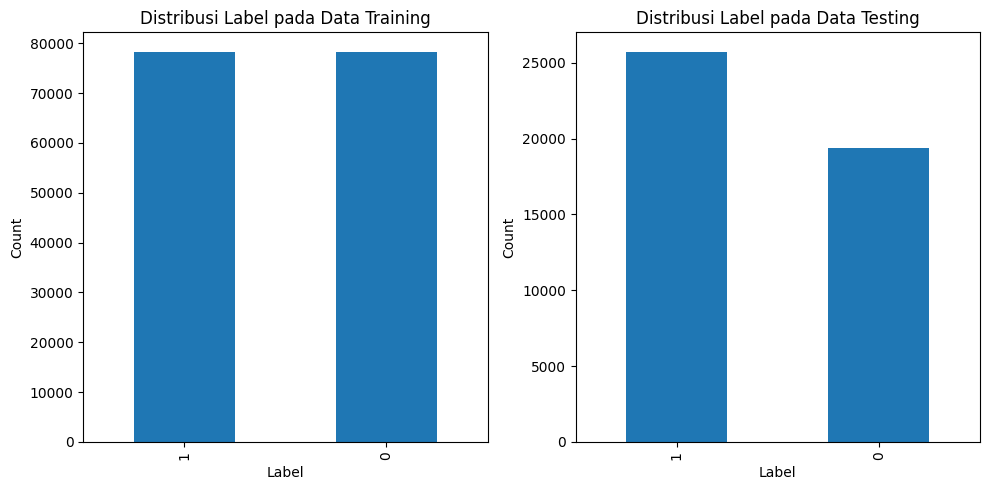

In [5]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt



# Bersihkan nama kolom dengan menghapus spasi ekstra di awal/akhir
df_train.columns = df_train.columns.str.strip()
df_test.columns = df_test.columns.str.strip()

# Pisahkan fitur dan label
X_train = df_train[[ 'Destination Port', 'Bwd Packet Length Max',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Max Packet Length',
       'Min Packet Length', 'Packet Length Mean', 'Packet Length Std',
       'Packet Length Variance', 'Avg Bwd Segment Size', 'Average Packet Size']]
y_train = df_train['Label']

X_test = df_test.drop('Label', axis=1)
y_test = df_test['Label']

# Pastikan kolom fitur konsisten
print("Kolom di X_train:", X_train.columns)
print("Kolom di X_test:", X_test.columns)

# Pastikan tidak ada kolom yang hilang
missing_in_test = set(X_train.columns) - set(X_test.columns)
missing_in_train = set(X_test.columns) - set(X_train.columns)

if missing_in_test or missing_in_train:
    raise ValueError(f"Kolom tidak konsisten!\nMissing in test: {missing_in_test}\nMissing in train: {missing_in_train}")

# Inisialisasi StandardScaler
scaler = StandardScaler()

# Fit scaler pada data training saja
X_train_scaled = scaler.fit_transform(X_train)

# Transform data test dengan scaler yang sama
X_test_scaled = scaler.transform(X_test)

# Reshape data menjadi bentuk [samples, timesteps, features]
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Tampilkan shape dari data yang telah di-reshape
print("Shape of X_train_reshaped:", X_train_reshaped.shape)
print("Shape of X_test_reshaped:", X_test_reshaped.shape)

# Plot distribusi label
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind='bar')
plt.title('Distribusi Label pada Data Training')
plt.xlabel('Label')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
y_test.value_counts().plot(kind='bar')
plt.title('Distribusi Label pada Data Testing')
plt.xlabel('Label')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


In [6]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, GRU

In [7]:
from keras.layers import Reshape

model = Sequential(
    [
        LSTM(64, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True),
        Dropout(0.3),
        GRU(32, return_sequences=False),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ]
)
model.summary()

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 64)          │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,897 (112.88 KB)

 Trainable params: 28,897 (112.88 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from keras.optimizers import Adam

# Compile the model with Adam optimizer and a learning rate of 0.00001
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
train = model.fit(X_train_reshaped,y_train, epochs=10, batch_size=32, validation_split=0.2)
train

Epoch 1/10
3915/3915 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7399 - loss: 0.6326 - val_accuracy: 0.7913 - val_loss: 0.4670
Epoch 2/10
3915/3915 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7922 - loss: 0.4405 - val_accuracy: 0.7915 - val_loss: 0.3534
Epoch 3/10
3915/3915 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7756 - loss: 0.3409 - val_accuracy: 0.7252 - val_loss: 0.2874
Epoch 4/10
3915/3915 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8231 - loss: 0.2846 - val_accuracy: 0.8781 - val_loss: 0.2551
Epoch 5/10
3915/3915 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8631 - loss: 0.2569 - val_accuracy: 0.8793 - val_loss: 0.2349
Epoch 6/10
3915/3915 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8756 - loss: 0.2385 - val_accuracy: 0.9022 - val_loss: 0.2176
Epoch 7/10
3915/3915 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8979 - loss: 0.2228 - val_accuracy: 0.9210 - val_loss: 0.2019
Epoch 8/10
3915/3915 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9144 - loss: 0.2

In [12]:
from sklearn.metrics import f1_score

# Pisahkan fitur dan label untuk df_test
X_test = df_test.drop('Label', axis=1)
y_test = df_test['Label']

# Normalisasi fitur menggunakan scaler yang telah dilatih
X_test_scaled = scaler.transform(X_test)

# Reshape data menjadi bentuk [samples, timesteps, features]
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Lakukan prediksi menggunakan model yang telah dilatih
y_pred = model.predict(X_test_reshaped)
y_pred = (y_pred > 0.5).astype(int)

# Hitung f1-score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

1411/1411 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
F1 Score: 0.9549097264833305


In [13]:
from sklearn.metrics import confusion_matrix

# Buat Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[17046  2371]
 [   54 25678]]


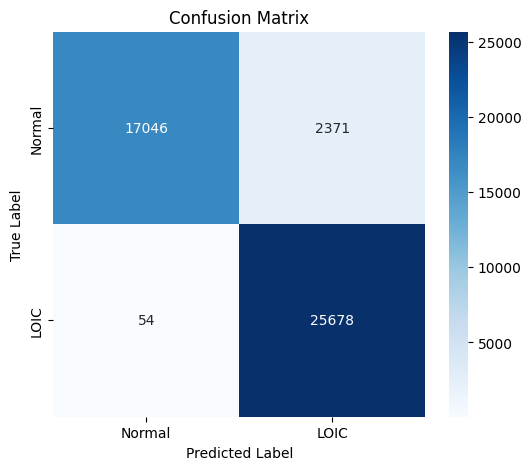

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Buat heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'LOIC'], yticklabels=['Normal', 'LOIC'])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
